In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from skfuzzy import defuzzify

## Problem Statement

* The process measurements are the angular position, about the vertical (ANG) and the angular velocity (VEL) of the pendulum.
* The fuzzy logic controller determines the control action (CNT), i.e. the current of the motor driving the positioning trolley.
* The objective of the fuzzy logic control is to keep the inverted pendulum upright.


* Angular position takes two fuzzy states with a support set [-30 deg, 30 deg]:
    * Positive large (PL)
    * Negative large (NL)
    
* Angular velocity takes two fuzzy states with a support set [-60 deg/s, 60 deg/s]:
    * Positive large (PL)
    * Negative large (NL)
    
* Control action takes three fuzzy states [-3, 3]:
    * Positive large (PL)
    * No Change (NC)
    * Negative large (NL)

![prob.png](../images/08/PendulumControl.PNG)

![prob2.png](../images/08/PendulumControl_statement.PNG)

In [20]:
class FuzzySys():
    def __init__(self):
        self.init_fuzzy()
        self.create_sys()

    def init_fuzzy(self):
        # Antecedent: Input
        # Consequent: Output
        ang_universe = np.arange(-30,30,0.5)
        vel_universe = np.arange(-60,60,1.0)
        cnt_universe = np.arange(-3.0, 3.0, 0.05)
        
        # New Antecedent/Consequent objects hold universe variables and membership
        # functions
        ang = ctrl.Antecedent(ang_universe, 'ang')
        vel = ctrl.Antecedent(vel_universe, 'vel')
        # Different defuzzification methods can be used, a full list can be found here
        # https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.defuzzify.html#skfuzzy.defuzzify.defuzz
        cnt = ctrl.Consequent(cnt_universe, 'cnt', defuzzify_method='centroid')


        # Assign membership functions
        # Angle Membership Functions
        ang['PL'] = fuzz.smf(ang_universe, -10, 20)
        ang['NL'] = fuzz.zmf(ang_universe, -20, 10)

        # ang velocity membership functions
        vel['PL'] = fuzz.smf(vel_universe, -20, 40)
        vel['NL'] = fuzz.zmf(vel_universe, -40, 20)

        # Membership function for control action
        cnt['PL'] = fuzz.smf(cnt_universe, 0, 2)
        cnt['NC'] = fuzz.trimf(cnt_universe, [-2, 0, 2])
        cnt['NL'] = fuzz.zmf(cnt_universe, -2, 0)        
        
        self.ang = ang
        self.vel = vel
        self.cnt = cnt

    def visualize(self, var_name):
        # Visualize the member functions using the *view()* method
        if var_name == 'ang':   self.ang.view()
        elif var_name == 'vel':    self.vel.view()
        elif var_name == 'cnt':       self.cnt.view()

    def setup_rules(self):
        # Fuzzy Rules
        
        rule1 = ctrl.Rule(self.ang['PL'] & self.vel['PL'], self.cnt['NL'])
        rule2 = ctrl.Rule(self.ang['PL'] & self.vel['NL'], self.cnt['NC'])
        rule3 = ctrl.Rule(self.ang['NL'] & self.vel['PL'], self.cnt['NC'])
        rule4 = ctrl.Rule(self.ang['NL'] & self.vel['NL'], self.cnt['PL'])
        return [rule1, rule2, rule3, rule4]
    
    def create_sys(self):
        # Create Control System (for inferencing)
        self.center_ctrl = ctrl.ControlSystem(self.setup_rules())

        # Create simulation
        self.center_sim = ctrl.ControlSystemSimulation(self.center_ctrl)


    def inference(self, ang, vel):
        # Provide inputs to the control simulation 
        self.center_sim.input['ang'] = ang
        self.center_sim.input['vel'] = vel
        
        # perform computation
        self.center_sim.compute()
        return self.center_sim.output['cnt']

The rules defined correspond to the following set of 4 rules:

Rules

1.  If ANG is PL and VEL is PL then CNT is NL
2. else if ANG is PL and VEL is NL then CNT is NC
3. else if ANG is NL and VEL is PL then CNT is NC
4. else if ANG is NL and VEL is NL then CNT is PL

In [21]:
# Creating the fuzzy system
fuzzsys = FuzzySys()

### Defined Membership Functions

**Angular Position**

D:\Programs\Anaconda3\envs\ece457b_venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


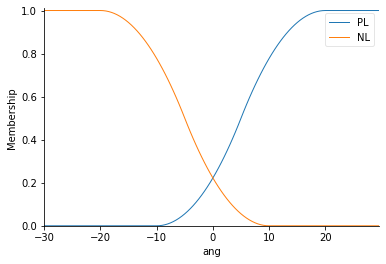

In [22]:
fuzzsys.visualize('ang')

**Angular Velocity**

D:\Programs\Anaconda3\envs\ece457b_venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


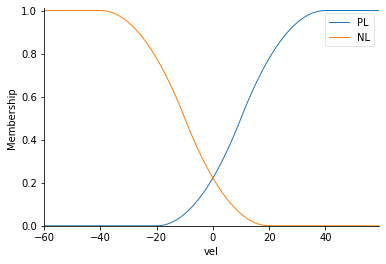

In [23]:
fuzzsys.visualize('vel')

**Cooling Rate**

D:\Programs\Anaconda3\envs\ece457b_venv\lib\site-packages\skfuzzy\control\fuzzyvariable.py:122: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


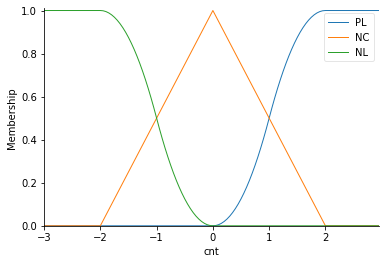

In [24]:
fuzzsys.visualize('cnt')

## Inferencing

In [25]:
fuzzsys.inference(15, 0)

-0.6093884582256665

Also refer to the documentation [here](https://pythonhosted.org/scikit-fuzzy/) and the [tipping problem](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_tipping_problem.html)